In [42]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!pip install kaggle

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-92ywss52
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-92ywss52
  Resolved https://github.com/albumentations-team/albumentations to commit 82818a0c4a80924d9f903a656c7f549ec6ca9cb2
  Preparing metadata (setup.py) ... done


# Download Dataset

In [43]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


# Imports

In [44]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [46]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15
# using CUDA for fast computations
DEVICE = 'cuda'

In [47]:
# CSV File containing image names in A,P,N triplet form
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [48]:
# taking a row of A,Pn,N and visualizing it
row = df.iloc[14]
A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

Text(0.5, 1.0, 'Negative')

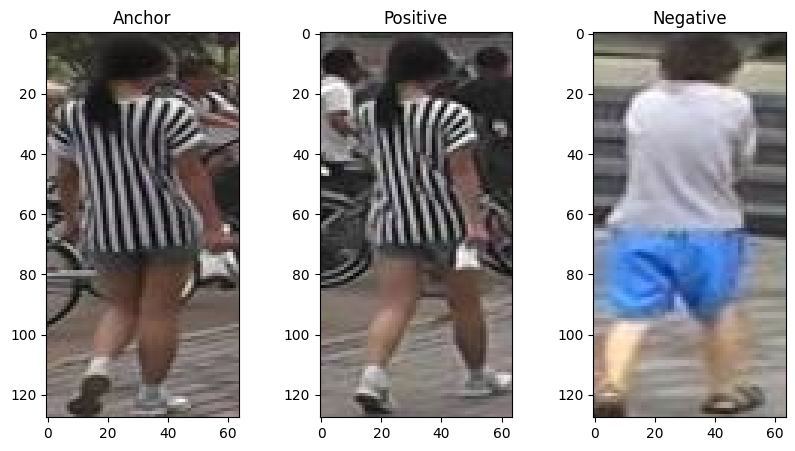

In [49]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,5))
ax1.imshow(A_img)
ax1.set_title("Anchor")
ax2.imshow(P_img)
ax2.set_title("Positive")
ax3.imshow(N_img)
ax3.set_title("Negative")

In [50]:
train_df, valid_df = train_test_split(df, test_size = 0.20)

# Create APN Dataset

In [51]:
class APN_Dataset(Dataset):
  """
  Class of Anchor, Positive and Negative (A,P,N) dataset so that object of this class can be utilized to directly acess items in df using idx
  """
  def __init__(self,df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]
    A_img = io.imread(DATA_DIR + row.Anchor)
    A_img = torch.from_numpy(A_img).permute(2,0,1)/255.0

    P_img = io.imread(DATA_DIR + row.Positive)
    P_img = torch.from_numpy(P_img).permute(2,0,1)/255.0

    N_img = io.imread(DATA_DIR + row.Negative)
    N_img = torch.from_numpy(N_img).permute(2,0,1)/255.0

    return A_img, P_img, N_img

In [52]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

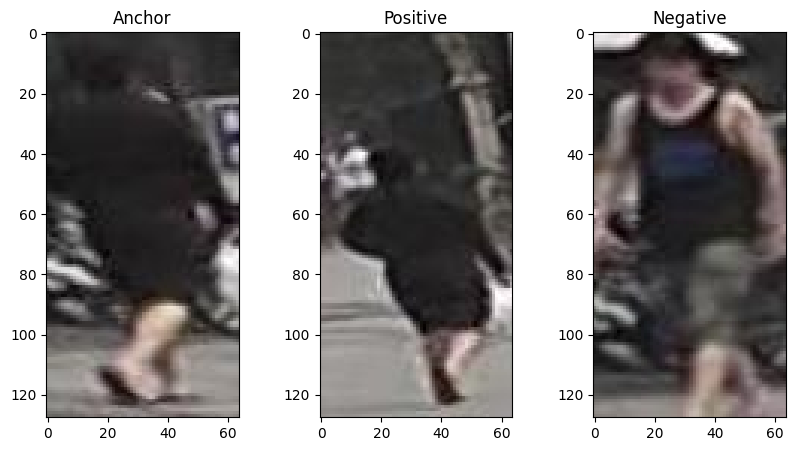

In [53]:
idx = 100
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [54]:
# Creating iterable data loaders for both training and validation data
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [55]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [56]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [57]:
# PyTorch neural network class representing an Anchor-Positive-Negative (APN) model.
# It uses the EfficientNet architecture as a backbone and replaces its classifier with a linear layer to produce embeddings of size emb_size
class APN_Model(nn.Module):
  def __init__(self, emb_size = 32):
    super(APN_Model,self).__init__()
    self.efficientnet = timm.create_model("efficientnet_b0", pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [58]:
# loading efficient net baseline (efficientnet_b0) model, and changing the final layer of nn to build a encoded vector of size 32
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [59]:
def train_fn(model, dataloader, optimizer, criterion):
  """
  Training function. It takes the model, a dataloader, an optimizer, and a criterion (loss function) as input. It returns average training loss over all batches
  """
  model.train()
  total_loss = 0.0
  # iterator over dataloader
  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
    # calculate embeddings for each image
    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)
    # calculate loss using embeddings of these images
    loss = criterion(A_embs, P_embs, N_embs)
    # tuning the parameters of the NN, using back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss / len(dataloader)


In [60]:
def eval_fn(model, dataloader, criterion):
  """
  Evaluation function. It takes the model, a dataloader and a criterion (loss function) as input. It returns average evaluation loss over all batches
  """
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for A,P,N in tqdm(dataloader):
      A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

      A_embs = model(A)
      P_embs = model(P)
      N_embs = model(N)

      loss = criterion(A_embs, P_embs, N_embs)
      total_loss += loss

  return total_loss / len(dataloader)

In [61]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [62]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  # calculates traing and eval loss in each EPOCH
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  eval_loss = eval_fn(model, validloader, criterion)
  # if evaluation loss this model is less than all other previous models, then save the model params
  if eval_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = eval_loss
    print("SAVED WEIGHTS SUCESS")

  print(f" EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {eval_loss}")


100%|██████████| 25/25 [00:02<00:00, 10.57it/s]


SAVED WEIGHTS SUCESS
 EPOCHS : 1 train_loss : 0.5773217919468879 valid_loss : 0.39984551072120667


100%|██████████| 25/25 [00:03<00:00,  7.97it/s]


SAVED WEIGHTS SUCESS
 EPOCHS : 2 train_loss : 0.2758085360378027 valid_loss : 0.20680634677410126


100%|██████████| 25/25 [00:02<00:00, 10.48it/s]


SAVED WEIGHTS SUCESS
 EPOCHS : 3 train_loss : 0.1498525205999613 valid_loss : 0.19116675853729248


100%|██████████| 25/25 [00:03<00:00,  8.03it/s]


SAVED WEIGHTS SUCESS
 EPOCHS : 4 train_loss : 0.10595017276704312 valid_loss : 0.17249171435832977


100%|██████████| 25/25 [00:02<00:00,  9.19it/s]


SAVED WEIGHTS SUCESS
 EPOCHS : 5 train_loss : 0.08082696713507176 valid_loss : 0.1318129301071167


100%|██████████| 25/25 [00:03<00:00,  7.78it/s]


 EPOCHS : 6 train_loss : 0.06908398240804672 valid_loss : 0.18654108047485352


100%|██████████| 25/25 [00:02<00:00, 10.44it/s]


 EPOCHS : 7 train_loss : 0.05525661081075668 valid_loss : 0.1962878406047821


100%|██████████| 25/25 [00:03<00:00,  7.89it/s]


 EPOCHS : 8 train_loss : 0.05161293961107731 valid_loss : 0.19515132904052734


100%|██████████| 25/25 [00:02<00:00, 10.69it/s]


 EPOCHS : 9 train_loss : 0.04257098220288753 valid_loss : 0.16520056128501892


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


 EPOCHS : 10 train_loss : 0.03845804840326309 valid_loss : 0.18680725991725922


100%|██████████| 25/25 [00:02<00:00,  9.97it/s]


SAVED WEIGHTS SUCESS
 EPOCHS : 11 train_loss : 0.06469788193702698 valid_loss : 0.12447898834943771


100%|██████████| 25/25 [00:03<00:00,  7.66it/s]


 EPOCHS : 12 train_loss : 0.04258739411830902 valid_loss : 0.15355391800403595


100%|██████████| 25/25 [00:02<00:00, 10.45it/s]


SAVED WEIGHTS SUCESS
 EPOCHS : 13 train_loss : 0.04227394014596939 valid_loss : 0.11863818764686584


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


SAVED WEIGHTS SUCESS
 EPOCHS : 14 train_loss : 0.017048076391220093 valid_loss : 0.09539631754159927


100%|██████████| 25/25 [00:02<00:00, 10.20it/s]

 EPOCHS : 15 train_loss : 0.016000244095921518 valid_loss : 0.1290806233882904



# Get Anchor Embeddings

In [63]:
def get_encoding_csv(model, anc_img_names):
  """
  calculate embeddings of each Anchor image and store them in csv file (Anchor image name, 32 columns of embeddings)
  """
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []
  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2,0,1)/255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [64]:

model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model,df["Anchor"])

100%|██████████| 4000/4000 [01:00<00:00, 66.19it/s]


In [65]:
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
0,1420_c5s3_052165_01.jpg,-2.051386,-0.839218,-1.277902,-1.685615,-0.066808,-0.243438,1.504763,-1.937031,0.789425,...,-3.020994,0.432883,3.779652,-0.426777,-0.598102,0.162826,-0.324123,1.753994,-1.387680,-0.235317
1,1420_c3s3_061978_03.jpg,-2.918118,-0.706352,-1.512670,-0.685085,-0.474720,0.284978,2.174732,-1.670168,1.012712,...,-1.708588,0.555410,2.731244,1.578126,0.485862,0.824820,0.759160,2.217648,-1.607842,-1.277211
2,1420_c5s3_062565_05.jpg,-3.139847,-0.713264,-1.037288,-1.890775,0.542794,-0.150434,1.451087,-1.285662,1.492033,...,-3.364479,1.837274,3.585345,1.692894,-0.320209,0.182636,1.010545,2.222099,-1.848845,-0.322404
3,1420_c6s3_085592_04.jpg,-2.640340,-0.622082,-0.622024,-1.451098,0.717352,0.374336,1.544006,-0.704990,1.366199,...,-3.218750,2.242307,3.204904,0.986428,-0.545388,-0.054562,0.719767,1.930814,-1.996283,-0.125121
4,0663_c5s3_085987_03.jpg,0.476004,1.320155,-1.048062,-2.537222,1.465495,-1.091672,-1.481627,4.106475,-0.079173,...,-2.077758,3.930304,0.470671,-1.838978,0.628019,-1.172006,0.066528,-1.365647,-2.104438,2.355751


# Inference

In [66]:
def euclidean_dist(img_enc, anc_enc_arr):
  """
    Calculate euclidean distance between a reference image, img_enc and other anchor image
  """
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [67]:
# Calculating encoding vector for reference image
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1)/255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [68]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy() # all except idx = 0, because anchor image at index 0 is reference
anc_img_names = df_enc['Anchor']

In [69]:
# calculate distance between reference image and all other images
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1,:])
  distance = np.append(distance, dist)

In [70]:
closest_idx = np.argsort(distance) # sorting the euclideadn distances between reference image and other anchor images

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:724: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


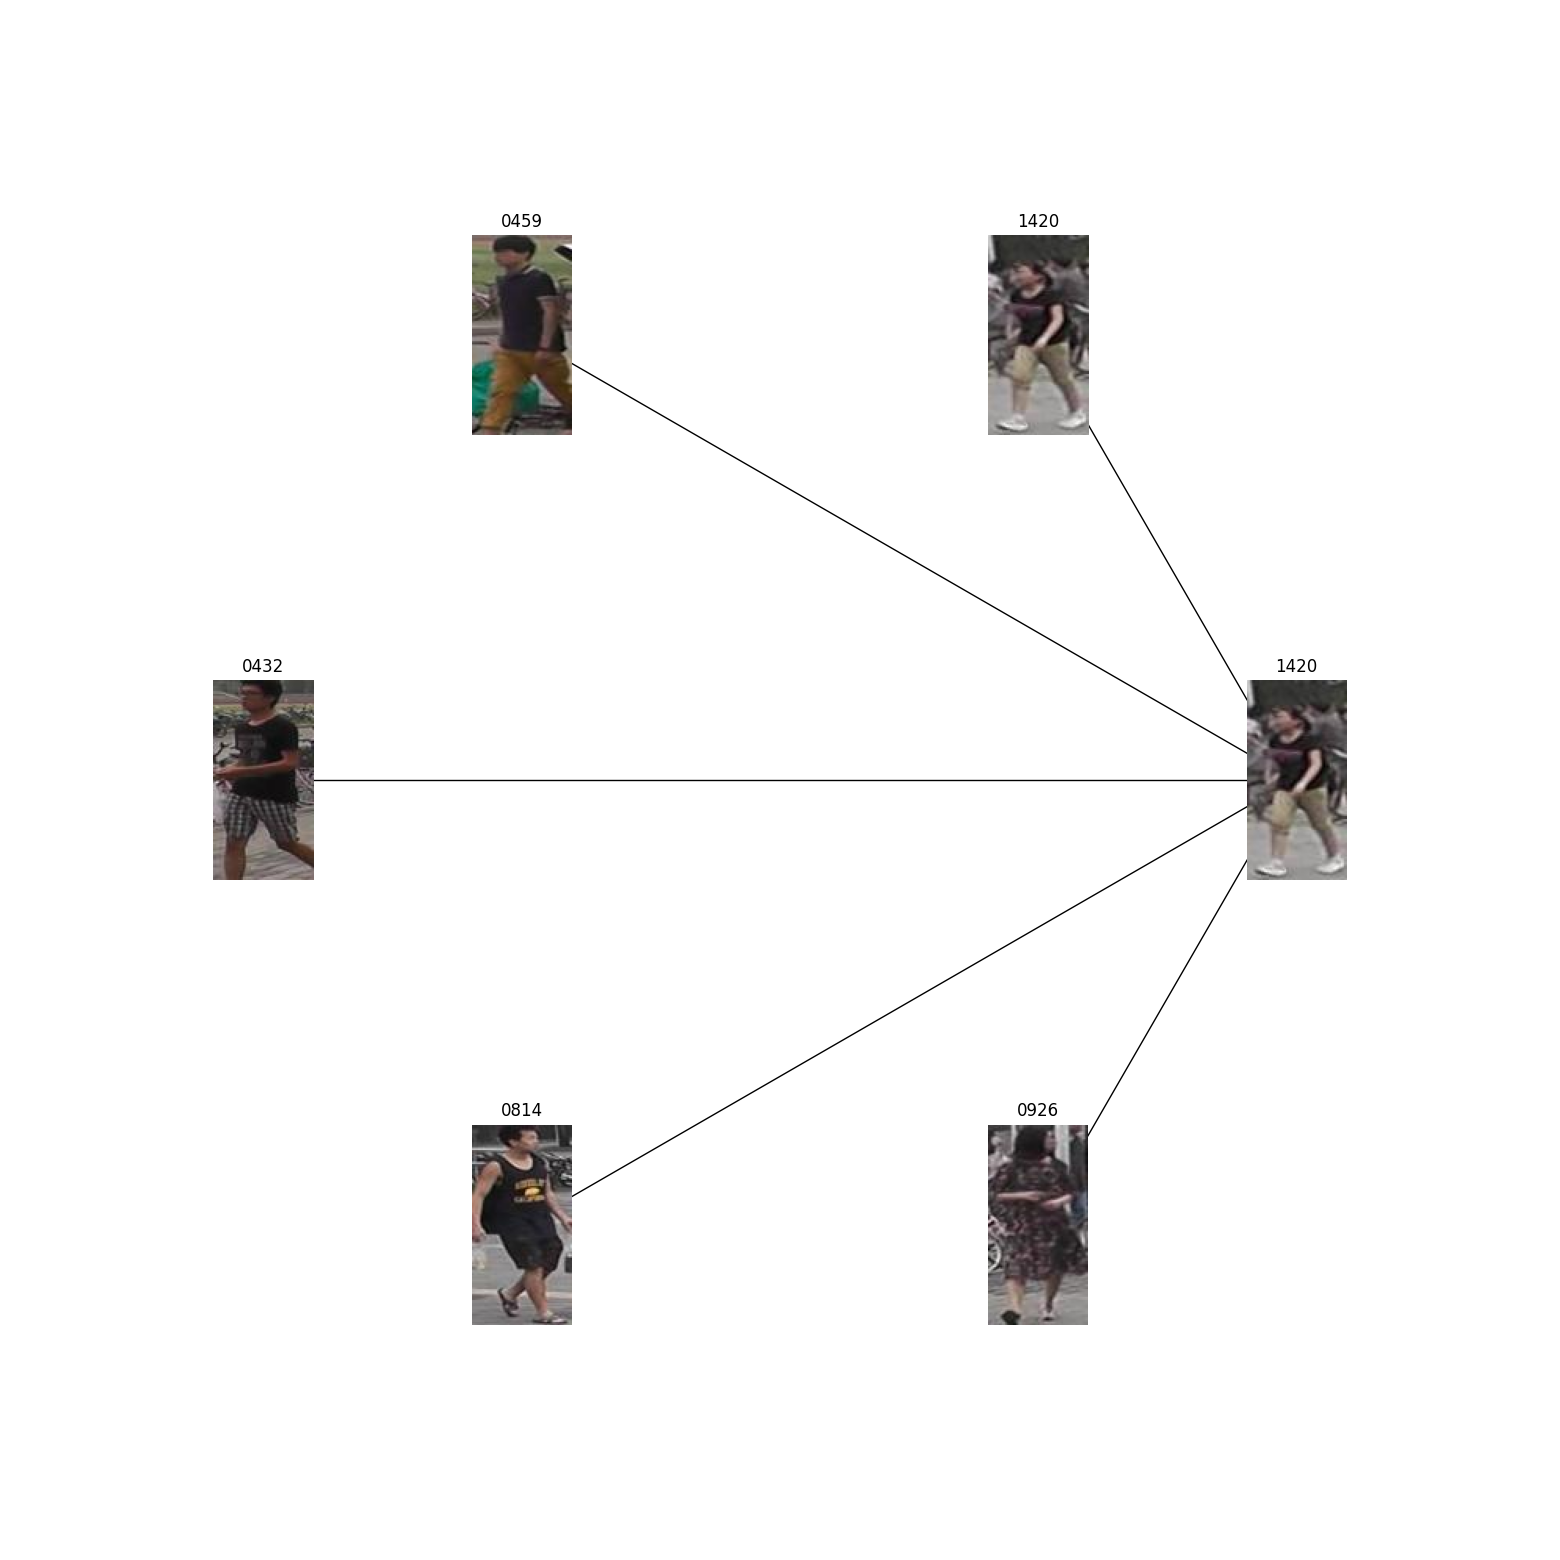

In [71]:
from utils import plot_closest_imgs
# ploting five images having closest euclidean distance with the reference image
plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);